In [1]:
!pip install torch pandas numpy scikit-learn matplotlib
!pip install torch torchvision torchaudio

Train files: [WindowsPath('C:/Users/Researcher/Desktop/LLaMA/train/train1.csv'), WindowsPath('C:/Users/Researcher/Desktop/LLaMA/train/train2.csv')]
Test files: [WindowsPath('C:/Users/Researcher/Desktop/LLaMA/test1/test1.csv'), WindowsPath('C:/Users/Researcher/Desktop/LLaMA/test1/test2.csv')]
(False, False, False)
(550800, 59)
444600
444600
(99940, 60, 30)
(99940, 60, 30)
(99940,)
Using device: cuda
Epoch 1/100, Train Loss: 0.010340923258512498, Valid Loss: 0.002082614052394156
Epoch 2/100, Train Loss: 0.001225753960860913, Valid Loss: 0.0007878697397940714
Epoch 3/100, Train Loss: 0.0007299843356822496, Valid Loss: 0.0005826624403233124
Epoch 4/100, Train Loss: 0.0005682371234693039, Valid Loss: 0.0004789165097324379
Epoch 5/100, Train Loss: 0.0004931700144790665, Valid Loss: 0.0004077127511438077
Epoch 6/100, Train Loss: 0.000467929440284414, Valid Loss: 0.000412951908326429
Epoch 7/100, Train Loss: 0.0004151983017874842, Valid Loss: 0.00036221944373308613
Epoch 8/100, Train Loss: 0.0

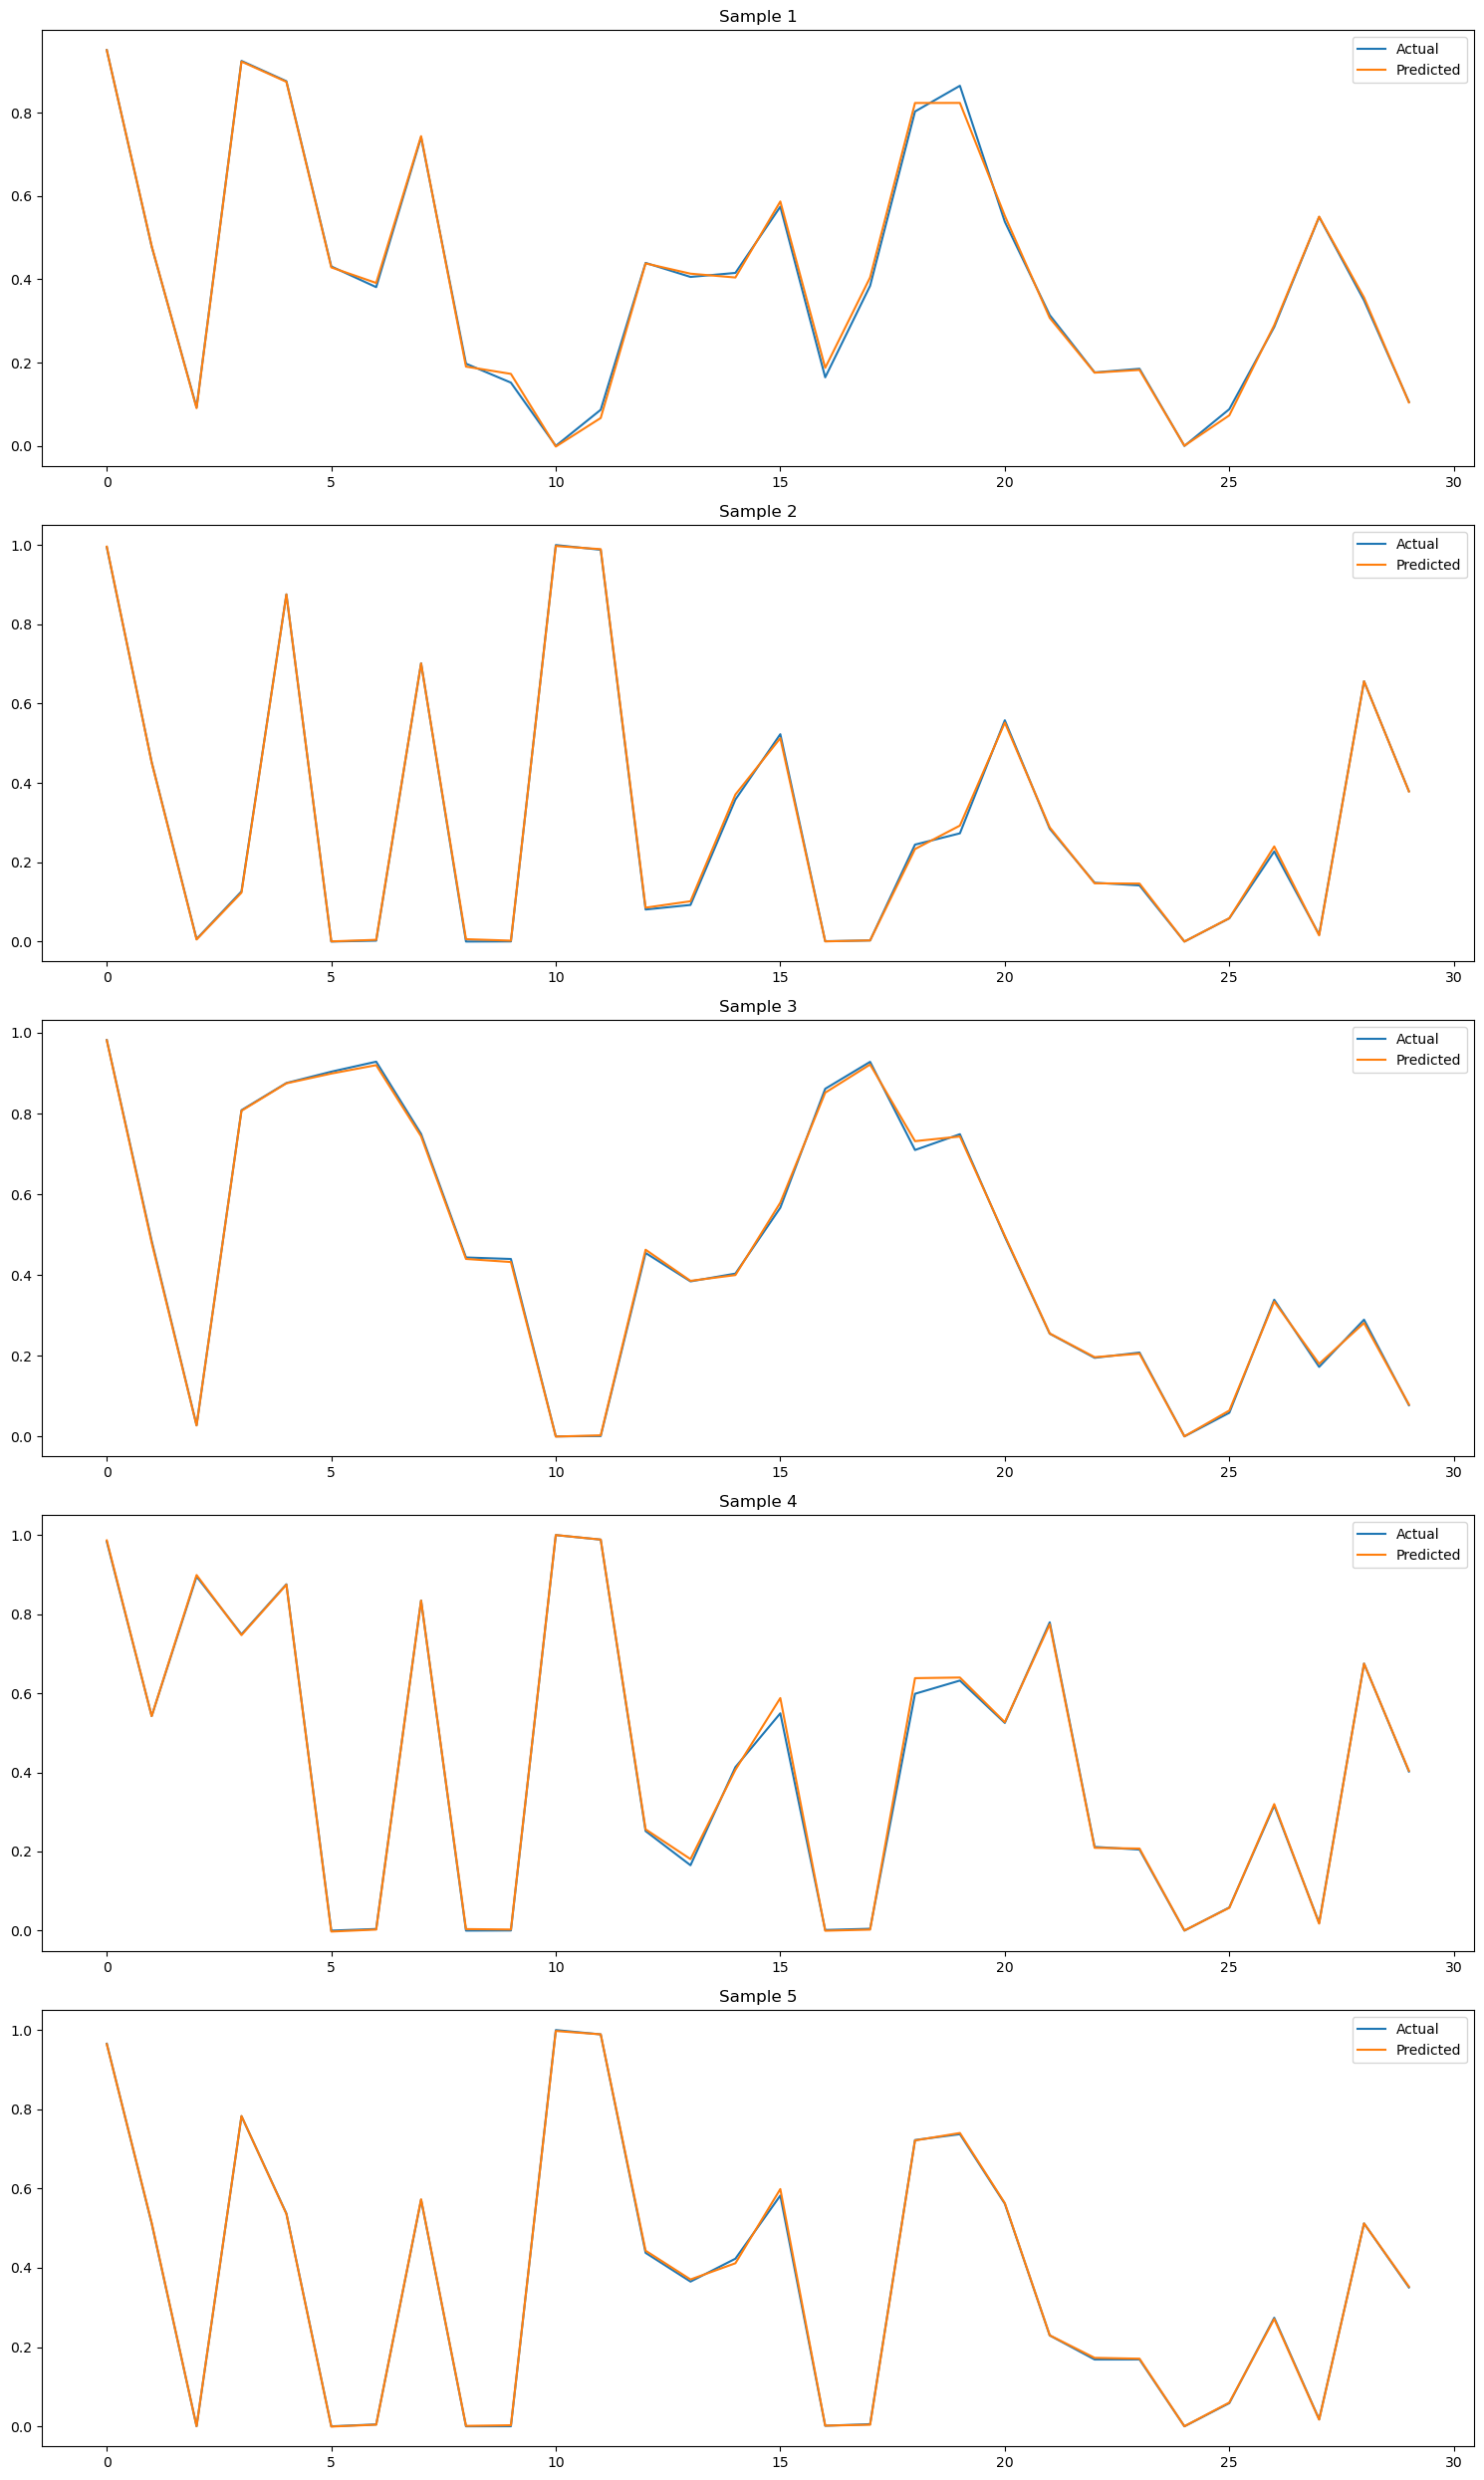

Mean Squared Error: 0.0006864517345093191
Mean Absolute Error: 0.005274444818496704
R^2 Score: 0.9420747662262309


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set directories
train_dir = Path(r"C:\Users\Researcher\Desktop\LLaMA\train")
test_dir = Path(r"C:\Users\Researcher\Desktop\LLaMA\test1")

# Verify files in directories
train_files = list(train_dir.glob("*.csv"))
test_files = list(test_dir.glob("*.csv"))

print("Train files:", train_files)
print("Test files:", test_files)

# Load datasets
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    if not targets:
        raise ValueError("No CSV files found in the directory.")
    return pd.concat([dataframe_from_csv(x) for x in targets])

# Get dataset files
TEST_DATASET = sorted([x for x in test_dir.glob("*.csv")])
TRAIN_DATASET = sorted([x for x in train_dir.glob("*.csv")])

# Load dataframes
try:
    TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
    TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
except ValueError as e:
    print(e)
    TRAIN_DF_RAW = pd.DataFrame()
    TEST_DF_RAW = pd.DataFrame()

# Check if dataframes are not empty
if not TRAIN_DF_RAW.empty and not TEST_DF_RAW.empty:
    ATTACK_DF = TEST_DF_RAW['attack']
    DROP_FIELD = ["time", "attack_P1", "attack_P2", "attack_P3", "attack"]
    VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop(DROP_FIELD)

    # Min-Max normalization
    TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
    TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

    def normalize(df, TAG_MIN, TAG_MAX):
        ndf = df.copy()
        for c in df.columns:
            if TAG_MIN[c] == TAG_MAX[c]:
                ndf[c] = df[c] - TAG_MIN[c]
            else:
                ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
        return ndf

    # Apply normalization and exponential weighted moving average
    TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET], TAG_MIN, TAG_MAX).ewm(alpha=0.9).mean()

    def boundary_check(df):
        x = np.array(df, dtype=np.float32)
        return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

    print(boundary_check(TRAIN_DF))
    print(TRAIN_DF.shape)
    train = np.array(TRAIN_DF)
    x_train = train.reshape(train.shape[0], 1, train.shape[1])
    print(len(TEST_DF_RAW))
    TEST_DF_RAW = TEST_DF_RAW.dropna()
    print(len(TEST_DF_RAW))
else:
    print("No training or testing data found. Please upload the files and try again.")

# Define sliding window function
window_size = 60
label_size = 100000

def sliding_window_unsupervised(df, window_size, feature_columns, answer_column):
    data = df[feature_columns].values
    answers = answer_column.values

    num_samples = len(df) - window_size
    features = np.empty((num_samples, window_size, len(feature_columns)), dtype=np.float32)
    targets = np.empty((num_samples, window_size, len(feature_columns)), dtype=np.float32)
    answer_targets = np.empty(num_samples, dtype=int)

    for i in range(num_samples):
        features[i] = data[i:i+window_size]
        targets[i] = data[i+window_size]
        answer_targets[i] = 1 if np.any(answers[i:i+window_size] == 1) else 0

    return features, targets, answer_targets

feature_columns = ['P1_B2004', 'P1_B2016', 'P1_B3004', 'P1_B3005', 'P1_B4002', 'P1_B4005', 'P1_B400B',
                   'P1_B4022', 'P1_FCV01D', 'P1_FCV01Z', 'P1_FCV02D', 'P1_FCV02Z', 'P1_FCV03D',
                   'P1_FCV03Z', 'P1_FT01', 'P1_FT01Z', 'P1_FT02', 'P1_FT02Z', 'P1_FT03', 'P1_FT03Z',
                   'P1_LCV01D', 'P1_LIT01', 'P1_PCV01D', 'P1_PCV01Z', 'P1_PCV02D', 'P1_PCV02Z',
                   'P1_PIT01', 'P1_PIT02', 'P1_TIT01', 'P1_TIT02']

features, targets, answers = sliding_window_unsupervised(TRAIN_DF[:label_size], 60, feature_columns, ATTACK_DF[:label_size])
print(features.shape)
print(targets.shape)
print(answers.shape)

# Split into train, validation, and test sets
features_train, features_valid, targets_train, targets_valid, labels_train, labels_valid = train_test_split(features, targets, answers, test_size=0.2, random_state=42)
features_train, features_test, targets_train, targets_test, labels_train, labels_test = train_test_split(features_train, targets_train, labels_train, test_size=0.25, random_state=42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Define a deeper LSTM autoencoder with dropout
class LLaMA3Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super(LLaMA3Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=3, batch_first=True, dropout=0.2)  # Increased LSTM layers with dropout

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x = self.encoder(x)
        x, _ = self.lstm(x)
        x = self.decoder(x[:, -1, :])  # Only decode the last time step
        return x

# Set hyperparameters
input_dim = len(feature_columns)
hidden_dim = 256  # Increased hidden dimension
seq_len = window_size
lr = 0.0005  # Adjusted learning rate
epochs = 100  # Increased epochs for better training
batch_size = 128  # Increased batch size

# Initialize the model
model = LLaMA3Autoencoder(input_dim, hidden_dim, seq_len).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)  # Learning rate scheduler

# Convert data to tensors and create DataLoader
train_dataset = TensorDataset(torch.tensor(features_train, dtype=torch.float32), torch.tensor(targets_train[:, -1, :], dtype=torch.float32))
valid_dataset = TensorDataset(torch.tensor(features_valid, dtype=torch.float32), torch.tensor(targets_valid[:, -1, :], dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(features_test, dtype=torch.float32), torch.tensor(targets_test[:, -1, :], dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop with validation and early stopping
best_valid_loss = float('inf')
early_stopping_patience = 10
no_improvement_count = 0

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch_features, batch_targets in train_loader:
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    model.eval()
    total_valid_loss = 0
    with torch.no_grad():
        for batch_features, batch_targets in valid_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            total_valid_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_valid_loss = total_valid_loss / len(valid_loader)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Valid Loss: {avg_valid_loss}')

    # Save the model if validation loss decreases
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save(model.state_dict(), 'best_model.pth')
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    scheduler.step(avg_valid_loss)

    # Early stopping
    if no_improvement_count >= early_stopping_patience:
        print("Early stopping triggered")
        break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluation on test data
model.eval()
predicted = []
with torch.no_grad():
    for batch_features, _ in test_loader:
        batch_features = batch_features.to(device)
        outputs = model(batch_features)
        predicted.append(outputs.cpu().numpy())
predicted = np.concatenate(predicted, axis=0)

# Plot actual vs predicted values
num_plots = 5  # Number of samples to plot

plt.figure(figsize=(15, num_plots * 5))
for i in range(num_plots):
    plt.subplot(num_plots, 1, i+1)
    plt.plot(features_test[i, -1, :].flatten(), label='Actual')
    plt.plot(predicted[i].flatten(), label='Predicted')
    plt.legend()
    plt.title(f'Sample {i+1}')
plt.tight_layout()
plt.show()

# Additional evaluation metrics
mse = np.mean((predicted - features_test[:, -1, :]) ** 2)
print(f'Mean Squared Error: {mse}')

# Calculate MAE and R^2 Score
mae = mean_absolute_error(features_test[:, -1, :], predicted)
print(f'Mean Absolute Error: {mae}')

r2 = r2_score(features_test[:, -1, :], predicted)
print(f'R^2 Score: {r2}')